In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
from scipy import *
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm

In [2]:
df_abgr = pd.read_csv('ABgroup.csv').drop_duplicates(subset = 'user_id')
df_cheat = pd.read_csv('Cheaters.csv').drop_duplicates(subset = 'user_id')
df_pltfrm = pd.read_csv('Platforms.csv').drop_duplicates(subset = 'user_id')
df_money = pd.read_csv('Money.csv')
df_cash = pd.read_csv('Cash.csv')

In [3]:
apc = pd.merge(df_abgr, df_pltfrm, on = 'user_id')
apc = apc.merge(df_cheat, on = 'user_id')

In [4]:
mc = pd.merge(df_money, df_cash)
common = pd.merge(mc, apc, on = ['user_id'])

In [5]:
df1 = common.groupby('user_id')[['money', 'cash']].sum()
df1 = df1.reset_index()

In [6]:
df2 = df_cheat[df_cheat['cheaters'] == 1].drop_duplicates(subset = 'user_id')
df2.drop('cheaters', axis= 1 , inplace= True)

In [7]:
df3 = pd.merge(df2, df1, on = 'user_id')

In [8]:
df4 = pd.concat([df1, df2], ignore_index= True)
df4 = df4.drop_duplicates(subset = 'user_id', keep = False)

In [9]:
new_cheat = pd.merge(df_money, df_cash)
new_cheat = new_cheat.merge(df_cheat)
new_cheat.drop('date', axis= 1 , inplace= True)
new_cheat = new_cheat.loc[new_cheat['cheaters'] != 1]
new_cheat.drop('cheaters', axis= 1 , inplace= True)
new_cheat = new_cheat.loc[new_cheat['money'] == 0]
new_cheat.drop('money', axis= 1 , inplace= True)
new_cheat = new_cheat.groupby(['user_id'], as_index=False).sum()
new_cheat

,user_id,cash
0,00036L-1T885I,2900
1,0004MK-MRBUKF,2050
2,0004MK-VW0O9L,1500
3,0005S4-UEC6BE,550
4,0007I5-EWUD6O,850
...,...,...
1070526,ZZZPEX-P2T8BH,1350
1070527,ZZZTEN-0QGZ3X,900
1070528,ZZZTR5-QSI6D3,4900
1070529,ZZZV9K-NM9B4Z,2300


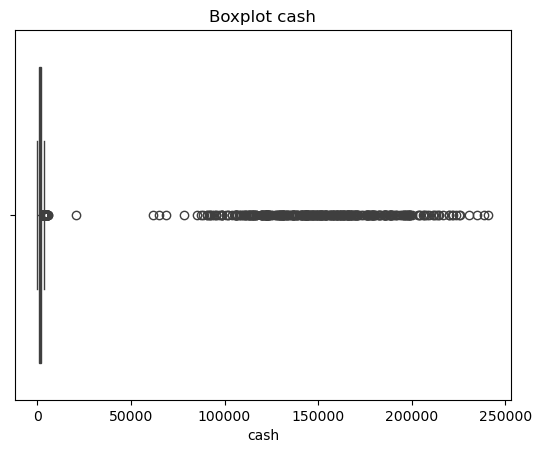

In [10]:
# наглядное выявление выбросов
sns.boxplot(x=new_cheat.cash)
plt.title('Boxplot cash')
plt.show()

In [11]:
Q1 = new_cheat.cash.quantile(0.25)
Q3 = new_cheat.cash.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - (3 * IQR) 
upper = Q3 + (3 * IQR)
cheaters = new_cheat[(new_cheat.cash < lower) | (new_cheat.cash > upper)]
print(f"Найдено потенциальных читеров: {len(cheaters)} из {len(new_cheat)} пользователей ")

Найдено потенциальных читеров: 374 из 1070531 пользователей 


In [12]:
def quantile_confidence_interval(df, column='cash', alpha=0.95):
    lower = df[column].quantile((1 - alpha) / 2)
    upper = df[column].quantile(1 - (1 - alpha) / 2)
    return (lower, upper)
    
confidence = quantile_confidence_interval(cheaters)

Text(0.5, 1.0, 'Доверительный интервал')

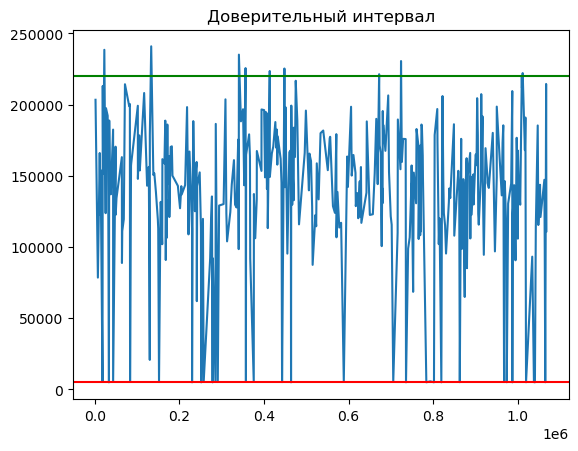

In [13]:
cheaters.cash.plot()
plt.axhline(y=confidence[1], color="g", linestyle="-")
plt.axhline(y=confidence[0], color="r", linestyle="-")
plt.title("Доверительный интервал")

In [14]:
clean = pd.concat([cheaters, df4])
clean = clean.drop_duplicates(subset = 'user_id', keep = False)

<Axes: >

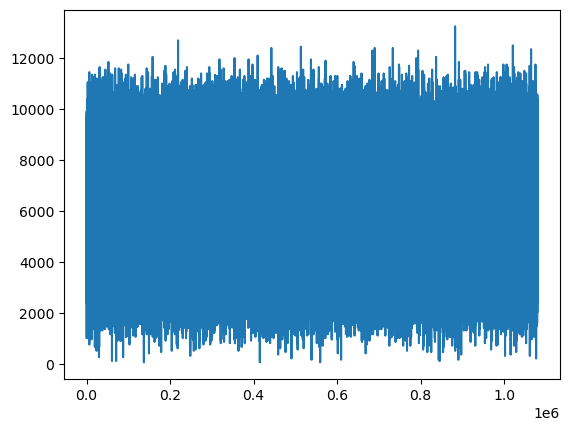

In [15]:
clean.cash.plot()

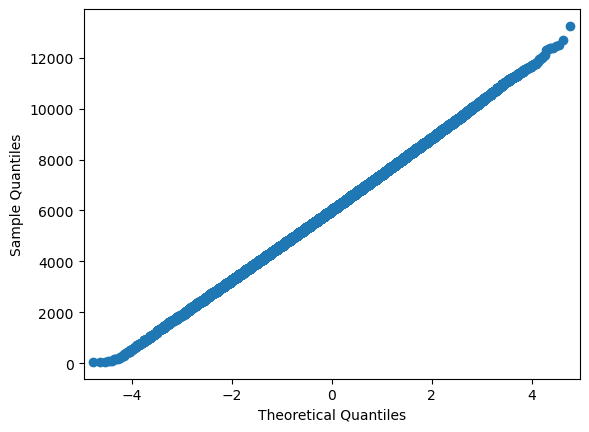

In [16]:
sm.qqplot(clean['cash'])
plt.show()

In [17]:
common_2 = common.copy()
common_2.drop('date', axis= 1 , inplace= True)
common_2 = common_2.groupby(['user_id', 'group', 'platform'], as_index=False).sum()

In [18]:
common_3 = pd.merge(clean, common_2, on = ['user_id', 'money', 'cash'], how = 'left')
del common_3['cheaters']
common_3

,user_id,cash,money,group,platform
0,00036L-1T885I,7600.0,3.97,control,XBox
1,0004MK-MRBUKF,6150.0,5.95,control,PS4
2,0004MK-VW0O9L,6300.0,4.96,test,PC
3,0005S4-UEC6BE,5000.0,5.95,test,PC
4,0007I5-EWUD6O,6350.0,6.94,test,PC
...,...,...,...,...,...
1079268,ZZZPEX-P2T8BH,6600.0,6.95,test,PC
1079269,ZZZTEN-0QGZ3X,4600.0,5.97,test,XBox
1079270,ZZZTR5-QSI6D3,5900.0,0.99,test,XBox
1079271,ZZZV9K-NM9B4Z,3900.0,3.97,control,PS4


In [19]:
control = common_3.loc[common_3['group'] == 'control']
control

,user_id,cash,money,group,platform
0,00036L-1T885I,7600.0,3.97,control,XBox
1,0004MK-MRBUKF,6150.0,5.95,control,PS4
5,0009DN-TWTJIG,7250.0,5.97,control,XBox
6,000A88-I8NCEL,4500.0,3.97,control,PS4
7,000B68-JX82RN,7200.0,5.95,control,PS4
...,...,...,...,...,...
1079258,ZZZ8PP-DTMHBH,4750.0,2.98,control,PS4
1079265,ZZZL1P-5DBOHS,6550.0,8.94,control,PS4
1079266,ZZZNBN-SJROHK,5450.0,4.95,control,PS4
1079271,ZZZV9K-NM9B4Z,3900.0,3.97,control,PS4


In [20]:
test = common_3.loc[common_3['group'] == 'test']
test

,user_id,cash,money,group,platform
2,0004MK-VW0O9L,6300.0,4.96,test,PC
3,0005S4-UEC6BE,5000.0,5.95,test,PC
4,0007I5-EWUD6O,6350.0,6.94,test,PC
13,000IF8-UU506H,5350.0,6.94,test,PS4
16,000IX6-VZLBS1,9900.0,10.95,test,PC
...,...,...,...,...,...
1079264,ZZZIS2-9EYJF3,7100.0,3.96,test,PC
1079267,ZZZONB-1W7QEW,6750.0,6.95,test,PC
1079268,ZZZPEX-P2T8BH,6600.0,6.95,test,PC
1079269,ZZZTEN-0QGZ3X,4600.0,5.97,test,XBox


# Доверительные интервалы групп с владельцами PS4

In [21]:
control_ps4 = control.loc[control['platform'] == 'PS4']
test_ps4 = test.loc[test['platform'] == 'PS4']

In [22]:
def conf(df, column):
    log_cash = np.log(df[column])
    mean = log_cash.mean()
    std = log_cash.std()
    ci_log = norm.interval(0.95, loc=mean, scale=std)
    ci_real = (np.expm1(ci_log[0]), np.expm1(ci_log[1]))  # Обратно в оригинальные единицы
    return ci_real

In [23]:
print(f'Контрольная группа: {conf(control_ps4, 'cash')}')
print(f'Тестовая группа: {conf(test_ps4, 'cash')}')

Контрольная группа: (3330.9537261003647, 9114.260605419806)
Тестовая группа: (3725.0436418203208, 9555.161327454549)


In [35]:
def cliffs_delta(x, y):
    nx = len(x)
    ny = len(y)
    more = 0
    less = 0
    for xi in x:
        more += np.sum(xi > y)
        less += np.sum(xi < y)
    delta = (more - less) / (nx * ny)
    return delta

In [34]:
from scipy.stats import mannwhitneyu
control_cash_1 = control_ps4['cash']
test_cash_1 = test_ps4['cash']
stat, p = mannwhitneyu(control_cash, test_cash, alternative='two-sided')
print(f"U-статистика = {stat:.2f}, p-value = {p:.4f}")

U-статистика = 13133228152.50, p-value = 0.0000


In [36]:
delta = cliffs_delta(test_cash_1.values, control_cash_1.values)
print(f"Cliff's Delta: {delta:.4f}")

Cliff's Delta: 0.1857


# Доверительные интервалы групп с владельцами XBox

In [27]:
control_xbox = control.loc[control['platform'] == 'XBox']
test_xbox = test.loc[test['platform'] == 'XBox']

print(f'Контрольная группа: {conf(control_xbox, 'cash')}')
print(f'Тестовая группа: {conf(test_xbox, 'cash')}')

Контрольная группа: (3666.4688526875057, 9680.789242969207)
Тестовая группа: (3709.6747975227536, 9716.000259400165)


In [37]:
control_cash_2 = control_xbox['cash']
test_cash_2 = test_xbox['cash']
stat, p = mannwhitneyu(control_cash, test_cash, alternative='two-sided')
print(f"U-статистика = {stat:.2f}, p-value = {p:.4f}")

U-статистика = 13133228152.50, p-value = 0.0000


In [38]:
delta = cliffs_delta(test_cash_2.values, control_cash_2.values)
print(f"Cliff's Delta: {delta:.4f}")

Cliff's Delta: 0.0180


# Доверительные интервалы групп с владельцами  PC

In [28]:
control_pc = control.loc[control['platform'] == 'PC']
test_pc = test.loc[test['platform'] == 'PC']

print(f'Контрольная группа: {conf(control_pc, 'cash')}')
print(f'Тестовая группа: {conf(test_pc, 'cash')}')

Контрольная группа: (3397.4875160476163, 8703.125987754296)
Тестовая группа: (3815.779556580088, 10075.981097882208)


In [39]:
control_cash_3 = control_pc['cash']
test_cash_3 = test_pc['cash']
stat, p = mannwhitneyu(control_cash, test_cash, alternative='two-sided')
print(f"U-статистика = {stat:.2f}, p-value = {p:.4f}")

U-статистика = 13133228152.50, p-value = 0.0000


In [40]:
delta = cliffs_delta(test_cash_3.values, control_cash_3.values)
print(f"Cliff's Delta: {delta:.4f}")

Cliff's Delta: 0.3224


#

In [29]:
common_clean = clean.copy()
del common_clean['cash']
del common_clean['money']

In [30]:
common_clean = pd.merge(common_clean, common, on = 'user_id', how = 'left')
common_clean.drop('cheaters', axis= 1 , inplace= True )
common_clean

,user_id,date,money,cash,group,platform
0,00036L-1T885I,10.07.2021,0.00,700,control,XBox
1,00036L-1T885I,16.07.2021,0.99,550,control,XBox
2,00036L-1T885I,11.07.2021,0.00,0,control,XBox
3,00036L-1T885I,12.07.2021,0.99,1500,control,XBox
4,00036L-1T885I,14.07.2021,0.00,650,control,XBox
...,...,...,...,...,...,...
8634179,ZZZVH1-2OJT7I,16.07.2021,0.00,550,control,PC
8634180,ZZZVH1-2OJT7I,13.07.2021,0.99,650,control,PC
8634181,ZZZVH1-2OJT7I,11.07.2021,0.99,150,control,PC
8634182,ZZZVH1-2OJT7I,10.07.2021,0.99,1350,control,PC


In [31]:
common_4 = common_3.copy()
del common_4['user_id']

# ARPU

In [32]:
common_4[common_4['group'] == 'control'].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,5587.069071,5.646294
PS4,5681.940466,5.737843
XBox,6131.786745,6.103629


In [33]:
common_4[common_4['group'] == 'test'].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,6381.745507,6.269169
PS4,6130.497294,6.084996
XBox,6176.398900,6.132960


# ARPPU

In [42]:
common_4[(common_4['money'] != 0) & (common_4['group'] == 'control')].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,5587.930881,5.648400
PS4,5682.680828,5.739567
XBox,6132.212831,6.104508


In [43]:
common_4[(common_4['money'] != 0) & (common_4['group'] == 'test')].groupby('platform').mean('cash', 'money')

,cash,money
platform,,
PC,6382.059767,6.269832
PS4,6130.929246,6.085980
XBox,6176.844143,6.133880


In [51]:
arpu1 = common_4[common_4['group'] == 'control'].groupby('platform', as_index=False).mean('cash', 'money')
arpu1.insert(loc= 3 , column='group', value='control')
arpu2 = common_4[common_4['group'] == 'test'].groupby('platform', as_index=False).mean('cash', 'money')
arpu2.insert(loc= 3 , column='group', value='test')
arpu = pd.concat([arpu1, arpu2], ignore_index= True)
arpu

,platform,cash,money,group
0,PC,5587.069071,5.646294,control
1,PS4,5681.940466,5.737843,control
2,XBox,6131.786745,6.103629,control
3,PC,6381.745507,6.269169,test
4,PS4,6130.497294,6.084996,test
5,XBox,6176.398900,6.132960,test
